<a href="https://colab.research.google.com/github/dornercr/INFO371/blob/main/INFO371_Healthcare_NLP_Vectorization_and_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

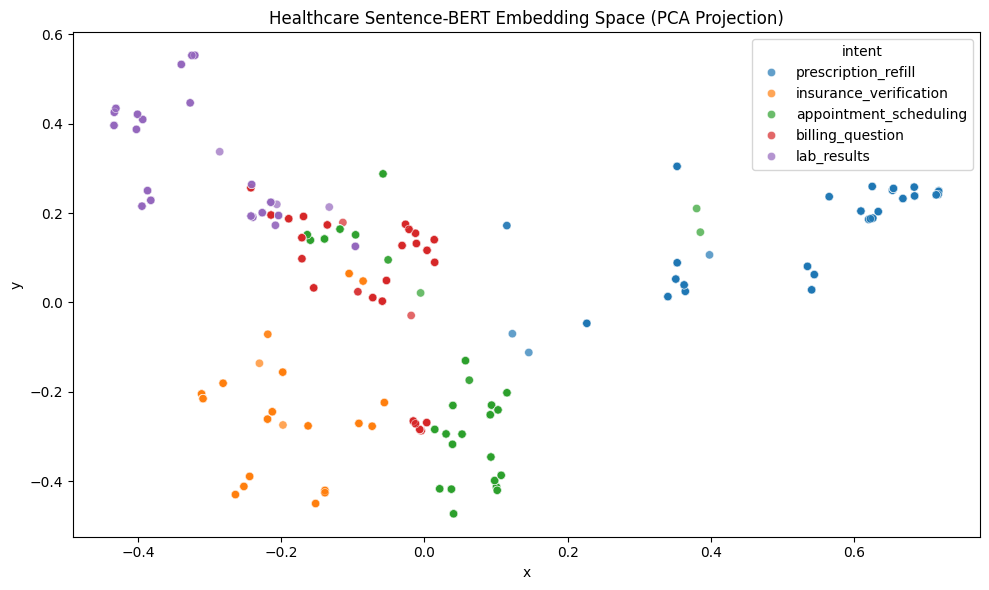

In [1]:
import random
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer

# 1. Define clean healthcare intents
intents = {
    "appointment_scheduling": [
        "I want to book an appointment.",
        "Can I schedule a doctor visit?",
        "Need to make a new appointment.",
        "How do I book a check-up?",
        "I’d like to set a medical appointment."
    ],
    "prescription_refill": [
        "I need a refill on my medication.",
        "Can I get my prescription refilled?",
        "Refill request for my last meds.",
        "I’m out of pills, need a refill.",
        "Renew my prescription please."
    ],
    "billing_question": [
        "Why is my bill so high?",
        "I have a question about my medical charges.",
        "Can someone explain my invoice?",
        "There’s a charge I don’t recognize.",
        "Help me understand my statement."
    ],
    "lab_results": [
        "Have my test results come in?",
        "How do I check my lab results?",
        "I want to view my bloodwork.",
        "Any update on my test findings?",
        "Where can I see my diagnostics?"
    ],
    "insurance_verification": [
        "Is my insurance accepted?",
        "Do you take my health plan?",
        "Can you verify my insurance coverage?",
        "Does my insurance cover this procedure?",
        "What plans do you work with?"
    ]
}

# 2. Generate clean samples
clean_data = []
for label, phrases in intents.items():
    for _ in range(300):
        base = random.choice(phrases)
        variation = random.choice([
            base,
            base.lower(),
            base.replace("?", "").strip() + "?",
            base.replace(".", ""),
            base + " Please advise.",
            "Hey, " + base[0].lower() + base[1:]
        ])
        clean_data.append((variation.strip(), label))

# 3. Add noisy samples (typos, slang, emojis)
noise_templates = {
    "appointment_scheduling": [
        "cant find where to book appt",
        "need see doc today maybe tomorrow",
        "tried making appt site froze",
        "set appointment asap please urgent",
        "how book check up again"
    ],
    "prescription_refill": [
        "meds ran out need refill fast",
        "refill last rx not showing in app",
        "where do i request pills again",
        "renewal needed cant skip dose",
        "trying get meds no response yet"
    ],
    "billing_question": [
        "charge not matching my visit date",
        "why 2 fees for same thing??",
        "bill came but no breakdown included",
        "payment higher than expected explain",
        "invoice shows test i never did"
    ],
    "lab_results": [
        "test done no result yet",
        "when do labs show up in portal",
        "result email never came",
        "doc said ready but not in system",
        "where check bloodwork from last week"
    ],
    "insurance_verification": [
        "accepted providers list not clear",
        "trying see if my plan works here",
        "insurance link broken cant verify",
        "covered or not for this kind of visit",
        "my plan changed need to check again"
    ]
}
noisy_data = []
for label, phrases in noise_templates.items():
    for _ in range(15):
        noisy_data.append((random.choice(phrases), label))

# 4. Add ambiguous/multi-intent/confusing phrases
confusing_samples = [
    ("Need to book and also get a refill", "appointment_scheduling"),
    ("Got a bill but I just checked lab too", "billing_question"),
    ("Trying to renew meds and also update my insurance", "prescription_refill"),
    ("Can’t see my test and charge seems off", "lab_results"),
    ("Saw doc now need follow-up and refill", "appointment_scheduling"),
    ("Insurance said denied, doc said approved", "insurance_verification"),
    ("Results came in but can’t open invoice", "lab_results"),
    ("I’m out of meds, bill not paid yet", "prescription_refill"),
    ("Need insurance check and blood test date", "insurance_verification"),
    ("Doctor visit set but lab not ready", "appointment_scheduling")
]
confusing_df = pd.DataFrame(confusing_samples, columns=["text", "intent"])

# 5. Combine all data
df_clean = pd.DataFrame(clean_data, columns=["text", "intent"])
df_noisy = pd.DataFrame(noisy_data, columns=["text", "intent"])
df_full = pd.concat([df_clean, df_noisy, confusing_df], ignore_index=True).sample(frac=1, random_state=42)

# 6. Vectorization & Classification: TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_full["text"])
y = df_full["intent"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
report_tfidf = classification_report(y_test, y_pred, output_dict=True)

# 7. Sentence Embeddings & Classification
model = SentenceTransformer("all-MiniLM-L6-v2")
X_embed = model.encode(df_full["text"].tolist(), show_progress_bar=False)
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_embed, y, stratify=y, test_size=0.2, random_state=42)
clf_embed = LogisticRegression(max_iter=1000)
clf_embed.fit(X_train_e, y_train_e)
y_pred_e = clf_embed.predict(X_test_e)
report_embed = classification_report(y_test_e, y_pred_e, output_dict=True)

# 8. Combine Reports
report_df = pd.DataFrame(report_tfidf).transpose().add_prefix("TFIDF_")
report_embed_df = pd.DataFrame(report_embed).transpose().add_prefix("EMBED_")
final_report = pd.concat([report_df, report_embed_df], axis=1)

# 9. Embedding Visualization
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_embed)
embed_vis_df = pd.DataFrame({"x": reduced[:, 0], "y": reduced[:, 1], "intent": df_full["intent"]})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=embed_vis_df, x="x", y="y", hue="intent", palette="tab10", alpha=0.7)
plt.title("Healthcare Sentence-BERT Embedding Space (PCA Projection)")
plt.tight_layout()
plt.show()


In [2]:
# 6b. Print TF-IDF Classification Report Summary
print("\n🔍 TF-IDF Classification Report (Summary):")
print(classification_report(y_test, y_pred))



🔍 TF-IDF Classification Report (Summary):
                        precision    recall  f1-score   support

appointment_scheduling       1.00      0.98      0.99        64
      billing_question       1.00      1.00      1.00        63
insurance_verification       1.00      0.98      0.99        63
           lab_results       0.98      1.00      0.99        63
   prescription_refill       0.98      1.00      0.99        64

              accuracy                           0.99       317
             macro avg       0.99      0.99      0.99       317
          weighted avg       0.99      0.99      0.99       317



In [3]:
# 7b. Print BERT Classification Report Summary
print("\n🔍 Sentence-BERT Classification Report (Summary):")
print(classification_report(y_test_e, y_pred_e))



🔍 Sentence-BERT Classification Report (Summary):
                        precision    recall  f1-score   support

appointment_scheduling       1.00      0.97      0.98        64
      billing_question       1.00      1.00      1.00        63
insurance_verification       1.00      1.00      1.00        63
           lab_results       0.98      1.00      0.99        63
   prescription_refill       0.98      1.00      0.99        64

              accuracy                           0.99       317
             macro avg       0.99      0.99      0.99       317
          weighted avg       0.99      0.99      0.99       317



In [4]:
# 8b. Show combined report sorted by f1-score
print("\n📊 Combined TF-IDF vs Sentence-BERT Report (Top Classes):")
display(final_report.sort_values("TFIDF_f1-score", ascending=False).head(10))



📊 Combined TF-IDF vs Sentence-BERT Report (Top Classes):


,TFIDF_precision,TFIDF_recall,TFIDF_f1-score,TFIDF_support,EMBED_precision,EMBED_recall,EMBED_f1-score,EMBED_support
billing_question,1.000000,1.000000,1.000000,63.000000,1.000000,1.000000,1.000000,63.000000
macro avg,0.993798,0.993700,0.993700,317.000000,0.993798,0.993750,0.993700,317.000000
accuracy,0.993691,0.993691,0.993691,0.993691,0.993691,0.993691,0.993691,0.993691
weighted avg,0.993789,0.993691,0.993690,317.000000,0.993789,0.993691,0.993665,317.000000
prescription_refill,0.984615,1.000000,0.992248,64.000000,0.984615,1.000000,0.992248,64.000000
appointment_scheduling,1.000000,0.984375,0.992126,64.000000,1.000000,0.968750,0.984127,64.000000
lab_results,0.984375,1.000000,0.992126,63.000000,0.984375,1.000000,0.992126,63.000000
insurance_verification,1.000000,0.984127,0.992000,63.000000,1.000000,1.000000,1.000000,63.000000
